In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [35]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score


In [36]:
df = pd.read_csv('mean_power.csv', sep=',', header=0, index_col=0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075259 entries, 1 to 2075259
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   DateTime               object 
dtypes: float64(7), object(1)
memory usage: 142.5+ MB


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
5,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [37]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.dtypes

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
DateTime                 datetime64[ns]
dtype: object

In [38]:
df.reset_index().set_index('DateTime')

,index,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,,
2006-12-16 17:24:00,1,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,2,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,3,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,4,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,5,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,2075255,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,2075256,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,2075257,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [39]:
df_corr = df.corr()
df_corr

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.245047,-0.395522,0.998887,0.483816,0.433892,0.639272
Global_reactive_power,0.245047,1.000000,-0.109030,0.264162,0.122743,0.139204,0.087743
Voltage,-0.395522,-0.109030,1.000000,-0.407198,-0.194100,-0.165348,-0.265510
Global_intensity,0.998887,0.264162,-0.407198,1.000000,0.488756,0.439713,0.627264
Sub_metering_1,0.483816,0.122743,-0.194100,0.488756,1.000000,0.055011,0.102704
Sub_metering_2,0.433892,0.139204,-0.165348,0.439713,0.055011,1.000000,0.080710
Sub_metering_3,0.639272,0.087743,-0.265510,0.627264,0.102704,0.080710,1.000000


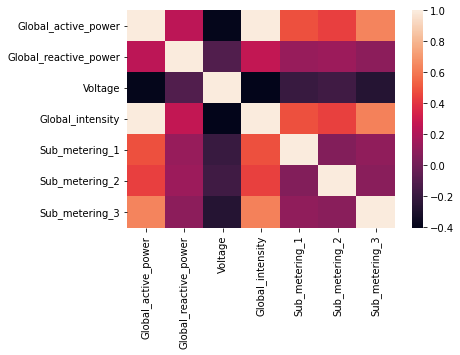

In [40]:
import seaborn as sns
sns.heatmap(df_corr)

In [41]:
df_day=df.resample('d', on='DateTime').mean()

df_day = df_day.drop('Voltage', axis=1 )

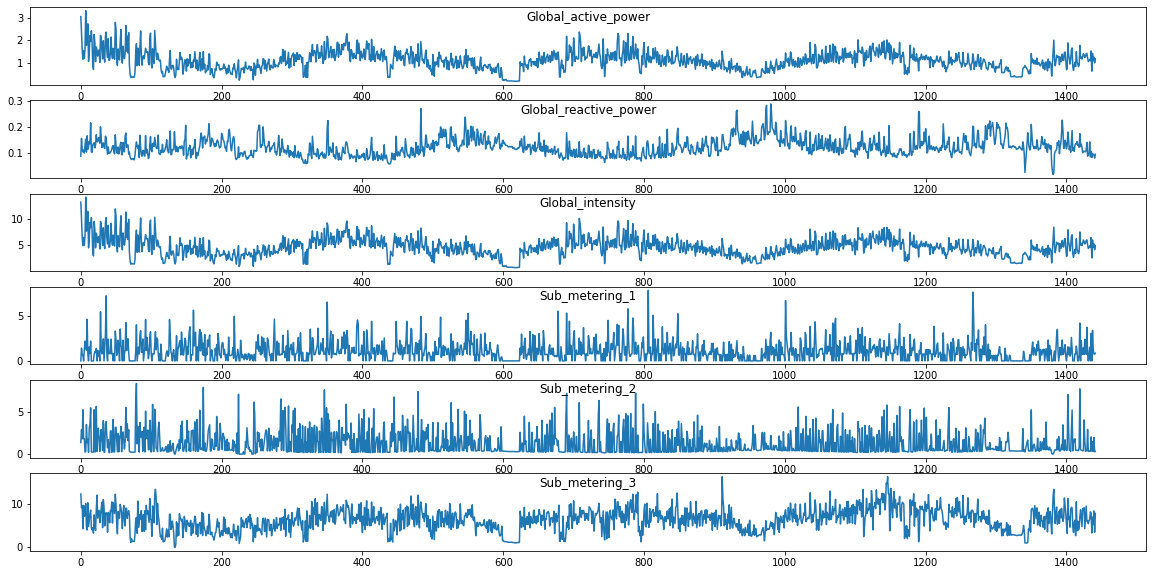

In [42]:
i = 1
cols=[0, 1, 2, 3, 4 ,5]
plt.figure(figsize=(20,10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df_day.values[:, col])
    plt.title(df_day.columns[col], y=0.75, loc='center')
    i += 1
plt.show()

In [43]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_day)
df_scaled =pd.DataFrame(scaled)

In [44]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [45]:
df_day["target"] = df_day.Global_active_power.shift(-1)
df_day = df_day.iloc[:-1,:]

In [46]:
values = df_day.values
num_test = 365

test = values[:num_test, :]
train = values[num_test:, :]

X_train, y_train = train[:,1:], train[:,0]
X_test, y_test = test[:,1:], test[:,0]

In [47]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(1076, 1, 6) (1076,) (365, 1, 6) (365,)


In [48]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1,activation='relu'))



In [49]:
model.compile(loss='mean_squared_error', optimizer='adam')



In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               42800     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), verbose = 2,shuffle=False)

Epoch 1/50
11/11 - 2s - loss: 0.8758 - val_loss: 0.4837 - 2s/epoch - 199ms/step
Epoch 2/50
11/11 - 0s - loss: 0.1555 - val_loss: 0.0725 - 80ms/epoch - 7ms/step
Epoch 3/50
11/11 - 0s - loss: 0.0543 - val_loss: 0.0652 - 75ms/epoch - 7ms/step
Epoch 4/50
11/11 - 0s - loss: 0.0459 - val_loss: 0.0607 - 78ms/epoch - 7ms/step
Epoch 5/50
11/11 - 0s - loss: 0.0283 - val_loss: 0.0757 - 85ms/epoch - 8ms/step
Epoch 6/50
11/11 - 0s - loss: 0.0324 - val_loss: 0.0689 - 79ms/epoch - 7ms/step
Epoch 7/50
11/11 - 0s - loss: 0.0282 - val_loss: 0.0580 - 88ms/epoch - 8ms/step
Epoch 8/50
11/11 - 0s - loss: 0.0272 - val_loss: 0.0547 - 87ms/epoch - 8ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0254 - val_loss: 0.0535 - 65ms/epoch - 6ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0235 - val_loss: 0.0500 - 65ms/epoch - 6ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0226 - val_loss: 0.0461 - 80ms/epoch - 7ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0204 - val_loss: 0.0438 - 69ms/epoch - 6ms/step
Epoch 13/50
11/11 - 0s - loss: 0.0202

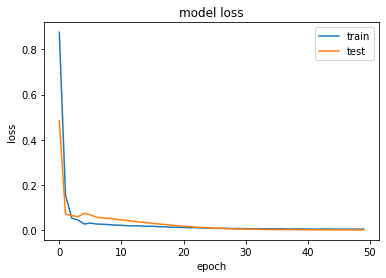

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [57]:
y_pred = model.predict(X_test)

In [64]:
X_test = X_test.reshape((X_test.shape[0], 6))

In [65]:
# Invert scaling for prediction
inv_x = np.concatenate((y_pred, X_test[:, -5:]), axis=1)
inv_x = scaler.inverse_transform(inv_x)
inv_y_pred = inv_x[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [66]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
print('RMSE value : {}'.format(rmse))

# calculate R2 Score
r2 = r2_score(inv_y, inv_y_pred)
print("R2 Score : {}".format(r2))

RMSE value : 0.14673698074952563
R2 Score : 0.9917497688098457


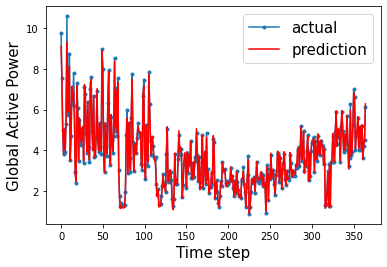

In [67]:
ap=[x for x in range(365)]
plt.plot(ap, inv_y[:365], marker='.', label="actual")
plt.plot(ap, inv_y_pred[:365], 'r', label="prediction")
plt.ylabel('Global Active Power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()